This is the full notebook with the majority of our work. Our repo is can be found here: https://github.com/evanflaks/451Project 

# Data Cleaning

In [292]:
import pandas as pd
import numpy as np

# Load dataset and filter to Power 5 games
df = pd.read_csv("cfb_box-scores_2002-2024.csv")

p5 = {"sec", "acc", "big10", "big12", "pac12"}
df = df[df["conf_home"].isin(p5) & df["conf_away"].isin(p5)].copy()

# Add game-level outcome for reference (not target)
df["point_diff"] = df["score_home"] - df["score_away"]

# Define base features for per-game averaging
features_to_average = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_att_home', 'pass_att_away',
    'third_down_comp_home', 'third_down_comp_away',
    'third_down_att_home', 'third_down_att_away',
    'pen_num_home', 'pen_num_away',
    'pen_yards_home', 'pen_yards_away',
    'fum_home', 'fum_away',
    'int_home', 'int_away',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away'
]

# Sort chronologically
df = df.sort_values(["season", "week"])

# Convert to long format for rolling averages
home_stats = df[["season", "week", "home"] + [f for f in features_to_average if f.endswith("_home")]].copy()
away_stats = df[["season", "week", "away"] + [f for f in features_to_average if f.endswith("_away")]].copy()

home_stats.columns = ["season", "week", "team"] + [f.replace("_home", "") for f in home_stats.columns[3:]]
away_stats.columns = ["season", "week", "team"] + [f.replace("_away", "") for f in away_stats.columns[3:]]

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(["team", "season", "week"])

# --- Custom feature engineering per team per game ---
team_stats["penalty_rate"] = team_stats["pen_yards"] / team_stats["pen_num"].replace(0, np.nan)
team_stats["turnovers"] = team_stats["fum"] + team_stats["int"]
team_stats["pass_eff"] = team_stats["pass_yards"] / team_stats["pass_att"].replace(0, np.nan)
team_stats["third_down_pct"] = team_stats["third_down_comp"] / team_stats["third_down_att"].replace(0, np.nan)

# --- Compute rolling averages (exclude current game) ---
all_rolling_feats = [
    'pass_yards', 'rush_yards', 'total_yards', 'pass_att',
    'third_down_comp', 'third_down_att', 'pen_num', 'pen_yards',
    'fum', 'int', 'first_downs', 'possession',
    'penalty_rate', 'turnovers', 'pass_eff', 'third_down_pct'
]

for feat in all_rolling_feats:
    team_stats[f"{feat}_avg"] = team_stats.groupby(["team", "season"])[feat].shift(1).expanding().mean()

# --- Merge rolling features back into main df for home and away teams ---
# For home
home_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
home_avg.columns = ["season", "week", "home"] + [f"{feat}_avg_home" for feat in all_rolling_feats]
df = df.merge(home_avg, on=["season", "week", "home"], how="left")

# For away
away_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
away_avg.columns = ["season", "week", "away"] + [f"{feat}_avg_away" for feat in all_rolling_feats]
df = df.merge(away_avg, on=["season", "week", "away"], how="left")

# Fill NaNs (early season games)
avg_cols = [col for col in df.columns if "_avg_" in col]
df[avg_cols] = df[avg_cols].fillna(0)

#For teams that are unranked, we will rank them 26

# --- Final feature and target setup ---
model_features = (
    [f"{feat}_avg_home" for feat in all_rolling_feats] +
    [f"{feat}_avg_away" for feat in all_rolling_feats] +
    ['rank_home', 'rank_away', 'neutral']
)

X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()


Only the top 25 teams are ranked in CFB, so we chose to impute the N/A values for the unranked teams as 26 for every team that isn't in the top 25 for a given week. 

In [293]:
# Fix rank columns: fill missing with 26 (unranked)
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)

# Ensure neutral is integer type
X["neutral"] = X["neutral"].astype(int)

In [294]:
X

,pass_yards_avg_home,rush_yards_avg_home,total_yards_avg_home,pass_att_avg_home,third_down_comp_avg_home,third_down_att_avg_home,pen_num_avg_home,pen_yards_avg_home,fum_avg_home,int_avg_home,...,int_avg_away,first_downs_avg_away,possession_avg_away,penalty_rate_avg_away,turnovers_avg_away,pass_eff_avg_away,third_down_pct_avg_away,rank_home,rank_away,neutral
0,227.774801,156.728703,379.234854,31.375487,5.536521,14.313347,5.379069,46.128796,0.718112,0.910917,...,0.904317,20.255369,26.059720,8.628327,1.613509,7.457099,0.387419,13.0,26.0,0
1,227.384694,156.839426,378.973864,31.292962,5.521011,14.281517,5.387598,46.168944,0.713700,0.903997,...,0.782152,21.685039,26.109974,8.552194,1.467192,8.093595,0.421920,10.0,26.0,0
2,229.408866,160.187227,384.243220,31.282881,5.528142,14.247594,5.458443,46.726451,0.735491,0.893847,...,0.896127,20.560739,25.831144,8.537351,1.636444,7.497680,0.386261,26.0,3.0,0
3,227.836879,158.091573,380.618481,31.172716,5.490613,14.233417,5.442011,46.477263,0.727159,0.896120,...,0.909896,20.302460,26.066662,8.643987,1.618245,7.447962,0.387069,13.0,11.0,0
4,229.408866,160.187227,384.243220,31.282881,5.528142,14.247594,5.458443,46.726451,0.735491,0.893847,...,0.895494,20.129665,25.813096,8.585388,1.625104,7.484326,0.384965,26.0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,231.722892,159.923439,386.800000,31.592881,5.575465,14.289485,5.473165,47.079189,0.708981,0.905257,...,0.902841,19.977788,25.975322,8.625031,1.618918,7.429962,0.385463,5.0,8.0,1
6950,231.722892,159.923439,386.800000,31.592881,5.575465,14.289485,5.473165,47.079189,0.708981,0.905257,...,0.902704,19.977791,25.975791,8.624761,1.618674,7.430693,0.385459,5.0,8.0,1
6951,231.728507,159.912277,386.794984,31.593692,5.575402,14.289563,5.473114,47.079947,0.709013,0.905268,...,0.902826,19.977180,25.974286,8.625079,1.619012,7.429540,0.385454,5.0,8.0,1
6952,231.728507,159.912277,386.794984,31.593692,5.575402,14.289563,5.473114,47.079947,0.709013,0.905268,...,0.902841,19.977788,25.975322,8.625031,1.618918,7.429962,0.385463,5.0,8.0,1


# Basic Linear Regression: First Attempt

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2
)

# Fit a baseline linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predict both home and away scores
y_pred = baseline_model.predict(X_test)

# Evaluate the model
mse_home = mean_squared_error(y_test["score_home"], y_pred[:, 0])
mse_away = mean_squared_error(y_test["score_away"], y_pred[:, 1])
mae_home = mean_absolute_error(y_test["score_home"], y_pred[:, 0])
mae_away = mean_absolute_error(y_test["score_away"], y_pred[:, 1])

print("=== Baseline Linear Regression ===")
print(f"Home Score MSE: {mse_home:.2f}, MAE: {mae_home:.2f}")
print(f"Away Score MSE: {mse_away:.2f}, MAE: {mae_away:.2f}")


=== Baseline Linear Regression ===
Home Score MSE: 166.80, MAE: 10.40
Away Score MSE: 158.72, MAE: 10.18


## Visualizations

Home R²: 0.13192892692752833
Away R²: 0.13614731412352565


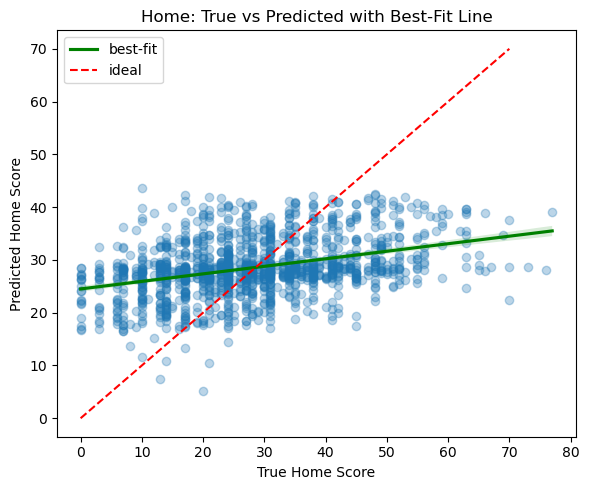

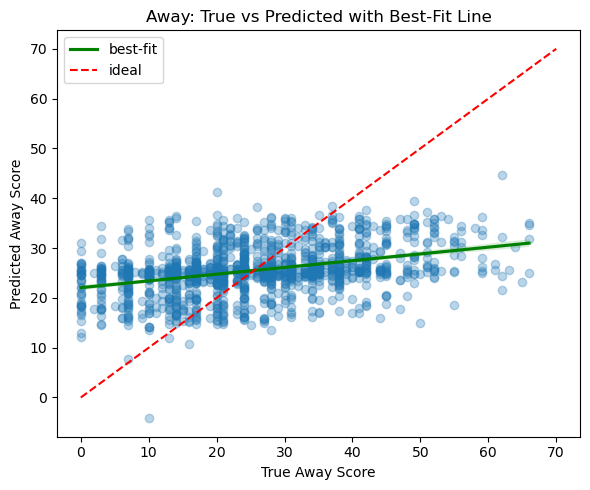

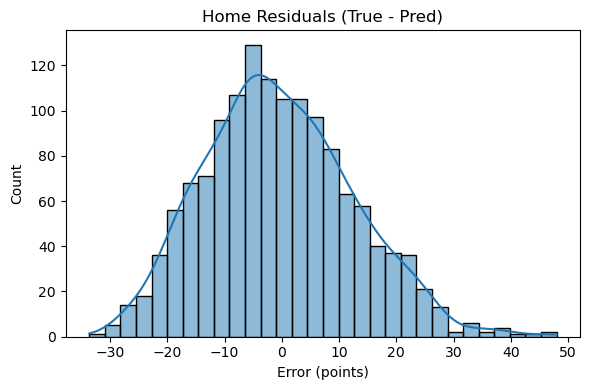

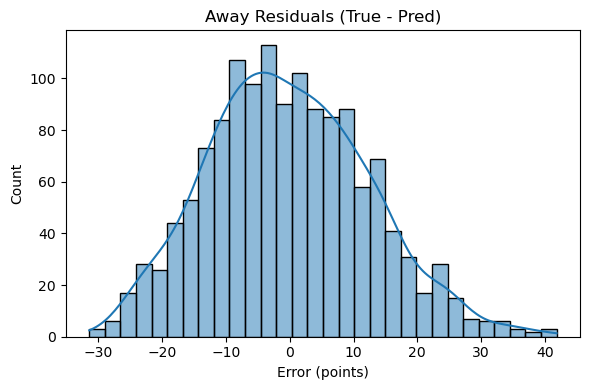

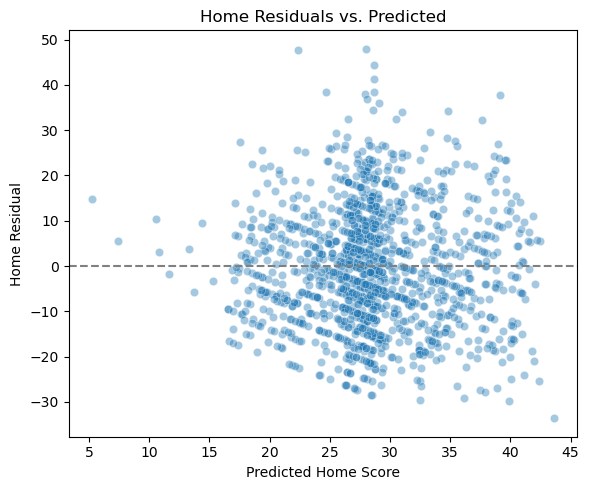

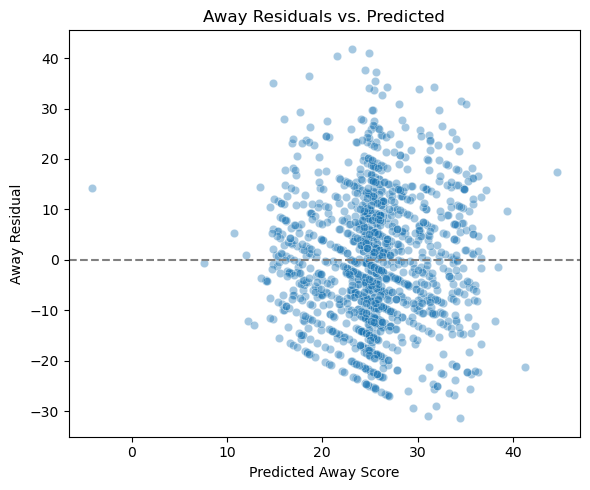

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# --- Step 1: Calculate True vs. Predicted Values ---
true_h = y_test["score_home"].values
pred_h = y_pred[:, 0]
true_a = y_test["score_away"].values
pred_a = y_pred[:, 1]

# --- Step 2: Compute Residuals ---
resid_home = true_h - pred_h
resid_away = true_a - pred_a

# --- Step 3: Build Visualization DataFrame ---
df_vis = pd.DataFrame({
    'true_home': true_h,
    'pred_home': pred_h,
    'resid_home': resid_home,
    'true_away': true_a,
    'pred_away': pred_a,
    'resid_away': resid_away
}, index=y_test.index)  # retain original indices for week/season

# If your test set also has 'week' and 'season', bring them in
if 'week' in y_test.columns:
    df_vis['week'] = y_test['week']
if 'season' in y_test.columns:
    df_vis['season'] = y_test['season']

# --- Step 4: R² Scores ---
print("Home R²:", r2_score(true_h, pred_h))
print("Away R²:", r2_score(true_a, pred_a))

# --- Step 5: True vs. Predicted Plot ---
plt.figure(figsize=(6, 5))
sns.regplot(x=true_h, y=pred_h, scatter_kws={"alpha": 0.3}, line_kws={"color": "green", "label": "best-fit"})
plt.plot([0, 70], [0, 70], "r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best-Fit Line")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.regplot(x=true_a, y=pred_a, scatter_kws={"alpha": 0.3}, line_kws={"color": "green", "label": "best-fit"})
plt.plot([0, 70], [0, 70], "r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best-Fit Line")
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 6: Residual Histograms ---
plt.figure(figsize=(6, 4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True - Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True - Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# --- Step 7: Residuals vs. Predicted ---
plt.figure(figsize=(6, 5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home Score")
plt.ylabel("Home Residual")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away Score")
plt.ylabel("Away Residual")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()




# Basic Linear Regression: Improved Features

In the initial version of the model, while the data processing was thorough and well-structured, there were several key limitations that likely impacted predictive accuracy. First, the use of expanding averages for team stats gave equal weight to all past games, failing to account for more recent performance, which is often more indicative of a team's current strength. Additionally, early-season games with no prior data were imputed with zeros, introducing unrealistic noise into the model. The train/test split was done randomly rather than chronologically, leading to potential data leakage from future games into the training set. Furthermore, the model lacked opponent-adjusted features, contextual variables like season or week, and did not address multicollinearity among highly correlated stats. In the improved version, we replaced expanding means with 4-game rolling averages to emphasize recent performance, used chronological train/test splitting to preserve time-series integrity, added deltas between home and away rolling stats to better capture relative matchups, and included season and week as control variables. We also applied mean imputation to handle any remaining missing values robustly and scaled features properly before fitting the model, resulting in a cleaner, more context-aware baseline.

In [298]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# 1. Load and Filter Dataset
# ===========================
df = pd.read_csv("cfb_box-scores_2002-2024.csv")

p5 = {"sec", "acc", "big10", "big12", "pac12"}
df = df[df["conf_home"].isin(p5) & df["conf_away"].isin(p5)].copy()
df["point_diff"] = df["score_home"] - df["score_away"]
df = df.sort_values(["season", "week"]).reset_index(drop=True)

# ===========================
# 2. Rolling Feature Engineering
# ===========================
features_to_average = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_att_home', 'pass_att_away',
    'third_down_comp_home', 'third_down_comp_away',
    'third_down_att_home', 'third_down_att_away',
    'pen_num_home', 'pen_num_away',
    'pen_yards_home', 'pen_yards_away',
    'fum_home', 'fum_away',
    'int_home', 'int_away',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away'
]

home_stats = df[["season", "week", "home"] + [f for f in features_to_average if f.endswith("_home")]].copy()
away_stats = df[["season", "week", "away"] + [f for f in features_to_average if f.endswith("_away")]].copy()
home_stats.columns = ["season", "week", "team"] + [f.replace("_home", "") for f in home_stats.columns[3:]]
away_stats.columns = ["season", "week", "team"] + [f.replace("_away", "") for f in away_stats.columns[3:]]

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(["team", "season", "week"])

# Derived stats
team_stats["penalty_rate"] = team_stats["pen_yards"] / team_stats["pen_num"].replace(0, np.nan)
team_stats["turnovers"] = team_stats["fum"] + team_stats["int"]
team_stats["pass_eff"] = team_stats["pass_yards"] / team_stats["pass_att"].replace(0, np.nan)
team_stats["third_down_pct"] = team_stats["third_down_comp"] / team_stats["third_down_att"].replace(0, np.nan)

# All rolling features (with a 4-game window)
all_rolling_feats = [
    'pass_yards', 'rush_yards', 'total_yards', 'pass_att',
    'third_down_comp', 'third_down_att', 'pen_num', 'pen_yards',
    'fum', 'int', 'first_downs', 'possession',
    'penalty_rate', 'turnovers', 'pass_eff', 'third_down_pct'
]

for feat in all_rolling_feats:
    team_stats[f"{feat}_avg"] = (
        team_stats
        .groupby(["team", "season"])[feat]
        .shift(1)
        .rolling(window=4, min_periods=1)
        .mean()
    )

# Merge back rolling averages
home_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
home_avg.columns = ["season", "week", "home"] + [f"{feat}_avg_home" for feat in all_rolling_feats]
df = df.merge(home_avg, on=["season", "week", "home"], how="left")

away_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
away_avg.columns = ["season", "week", "away"] + [f"{feat}_avg_away" for feat in all_rolling_feats]
df = df.merge(away_avg, on=["season", "week", "away"], how="left")

# Intelligent imputation
avg_cols = [col for col in df.columns if "_avg_" in col]
feature_means = df[avg_cols].mean()
df[avg_cols] = df[avg_cols].fillna(feature_means)

# ===========================
# 3. Feature Engineering: Deltas and Control Vars
# ===========================
# Compute home-away deltas
for feat in all_rolling_feats:
    df[f"{feat}_delta"] = df[f"{feat}_avg_home"] - df[f"{feat}_avg_away"]

# Final feature set
model_features = [f"{feat}_delta" for feat in all_rolling_feats] + [
    'rank_home', 'rank_away', 'neutral', 'season', 'week'
]

# Target variables
X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()

# Fix ranks and neutral
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)
X["neutral"] = X["neutral"].astype(int)

# ===========================
# 4. Chronological Train/Test Split
# ===========================
train_df = df[df["season"] < 2022].copy()
test_df = df[df["season"] >= 2022].copy()

X_train = X.loc[train_df.index]
X_test = X.loc[test_df.index]
y_train = y.loc[train_df.index]
y_test = y.loc[test_df.index]

# Fill any remaining NaNs with column means (safety net)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # use train mean for consistency


# ===========================
# 5. Scale and Fit Linear Model
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# ===========================
# 6. Evaluate Results
# ===========================
mse_home = mean_squared_error(y_test["score_home"], y_pred[:, 0])
mae_home = mean_absolute_error(y_test["score_home"], y_pred[:, 0])
mse_away = mean_squared_error(y_test["score_away"], y_pred[:, 1])
mae_away = mean_absolute_error(y_test["score_away"], y_pred[:, 1])

print("=== Improved Linear Regression Model ===")
print(f"Home Score - MSE: {mse_home:.2f}, MAE: {mae_home:.2f}")
print(f"Away Score - MSE: {mse_away:.2f}, MAE: {mae_away:.2f}")


=== Improved Linear Regression Model ===
Home Score - MSE: 152.29, MAE: 10.05
Away Score - MSE: 138.24, MAE: 9.60


## Visualizations

Home R²: 0.11223269358333654


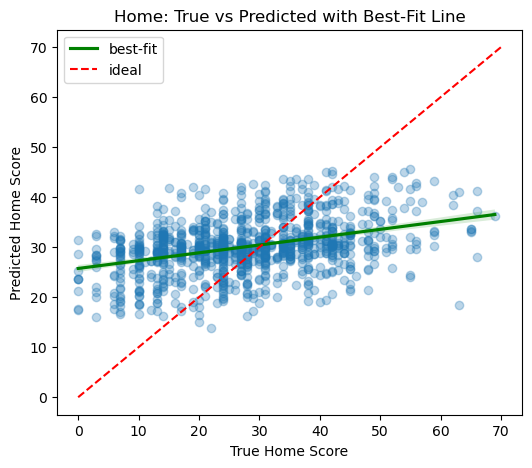

Away R²: 0.09936412375547488


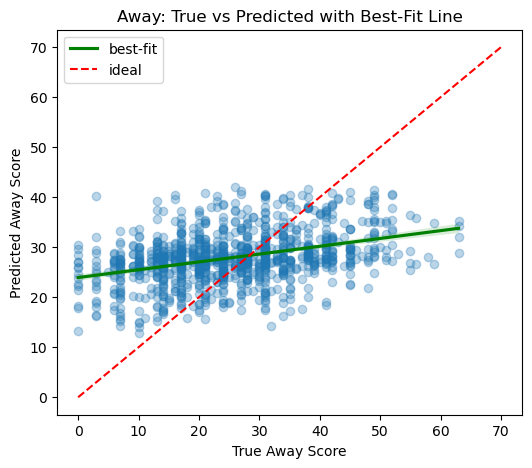

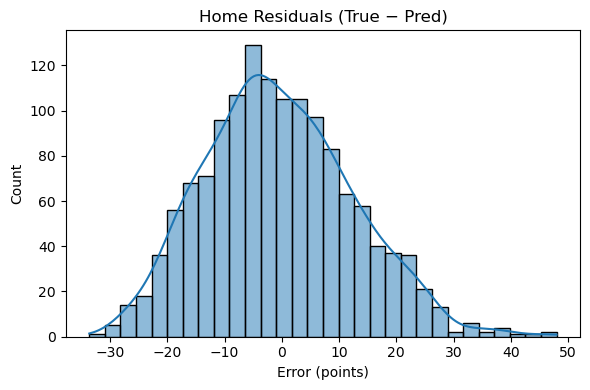

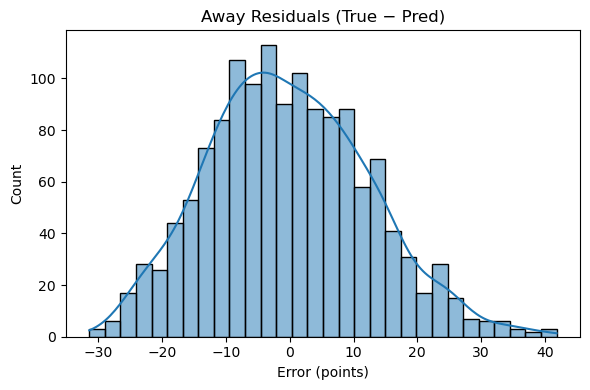

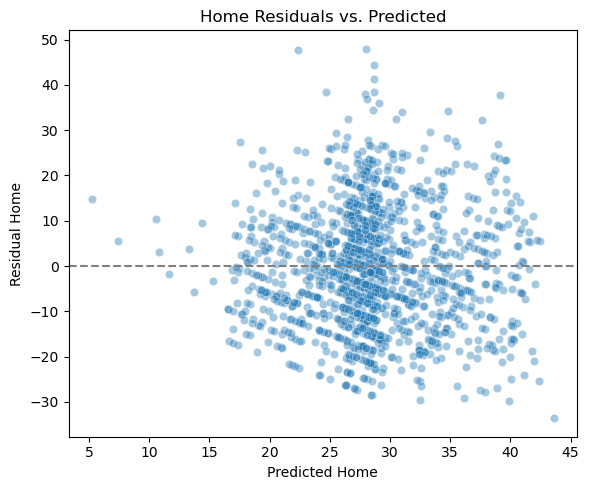

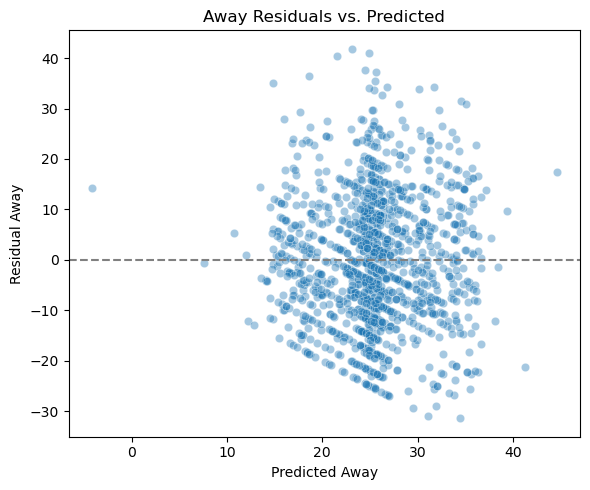

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Home score
true_h = y_test["score_home"].values
pred_h = y_pred[:,0]

print("Home R²:", r2_score(true_h, pred_h))

plt.figure(figsize=(6,5))
sns.regplot(x=true_h, y=pred_h,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()

# Away score
true_a = y_test["score_away"].values
pred_a = y_pred[:,1]

print("Away R²:", r2_score(true_a, pred_a))

plt.figure(figsize=(6,5))
sns.regplot(x=true_a, y=pred_a,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()



# 3) Residual histograms
plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True − Pred)") 
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True − Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# 4) Residuals vs. Predicted (check for heteroscedasticity)
plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home")
plt.ylabel("Residual Home")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away")
plt.ylabel("Residual Away")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()



Home R²: 0.11223269358333654


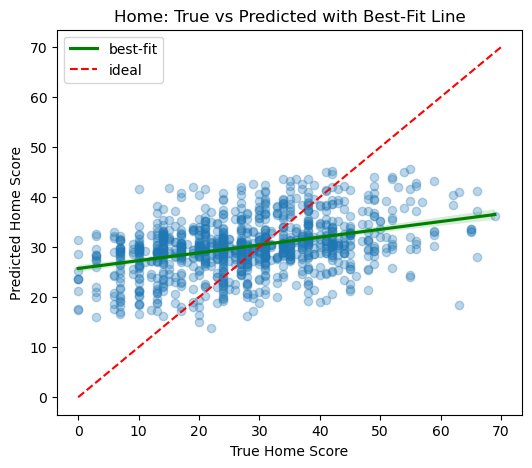

Away R²: 0.09936412375547488


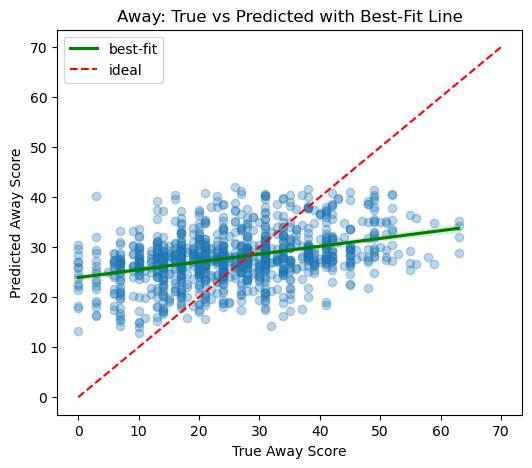

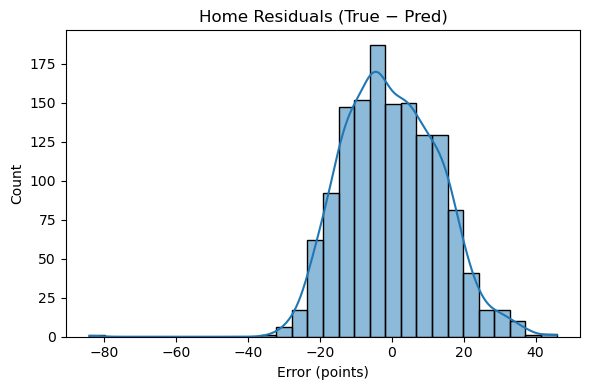

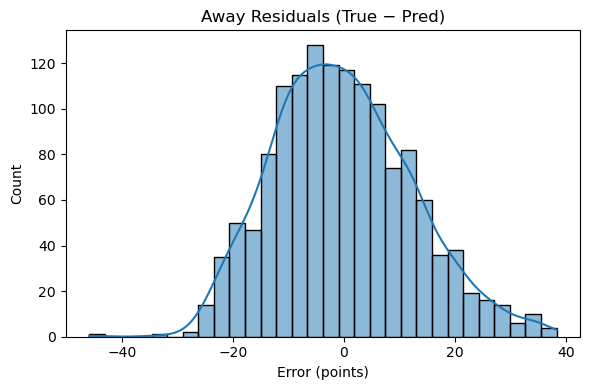

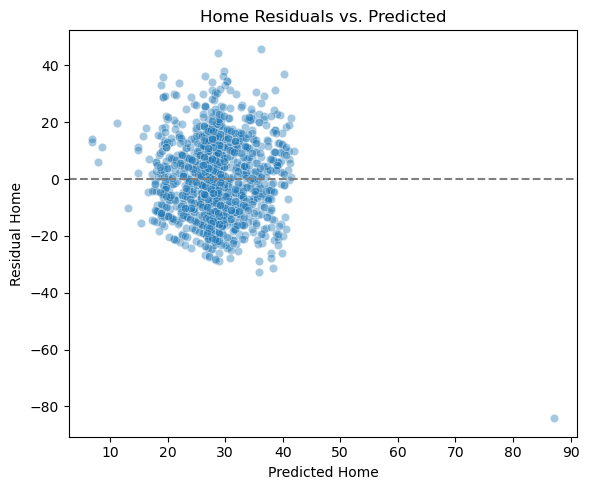

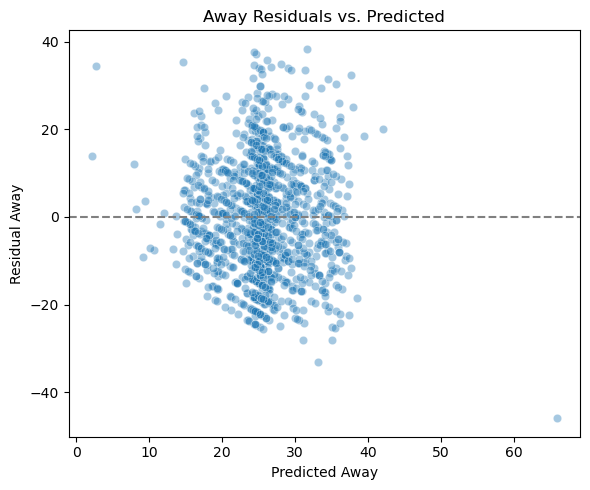

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Home score
true_h = y_test["score_home"].values
pred_h = y_pred[:,0]

print("Home R²:", r2_score(true_h, pred_h))

plt.figure(figsize=(6,5))
sns.regplot(x=true_h, y=pred_h,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()

# Away score
true_a = y_test["score_away"].values
pred_a = y_pred[:,1]

print("Away R²:", r2_score(true_a, pred_a))

plt.figure(figsize=(6,5))
sns.regplot(x=true_a, y=pred_a,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()



# 3) Residual histograms
plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True − Pred)") 
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True − Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# 4) Residuals vs. Predicted (check for heteroscedasticity)
plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home")
plt.ylabel("Residual Home")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away")
plt.ylabel("Residual Away")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()



# Neural Networks

In [ ]:
%load_ext autoreload
%autoreload 2
from cfb import FootballNet, MultiObjectiveLoss, FootballNetSplit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this section, we are tuning our model. We are going to tune our 

In [286]:
X

,pass_yards_delta,rush_yards_delta,total_yards_delta,pass_att_delta,third_down_comp_delta,third_down_att_delta,pen_num_delta,pen_yards_delta,fum_delta,int_delta,...,possession_delta,penalty_rate_delta,turnovers_delta,pass_eff_delta,third_down_pct_delta,rank_home,rank_away,neutral,season,week
0,44.666667,37.666667,82.333333,4.000000,-1.333333,-2.333333,-3.333333,-26.000000,-0.333333,-0.666667,...,2.706667,1.071429,-1.000000,0.595998,-0.025439,13.0,26.0,0,2002,1.0
1,-63.333333,154.000000,90.666667,-8.000000,-4.333333,-4.333333,-1.000000,-9.666667,0.000000,1.000000,...,-0.130000,0.036111,1.000000,0.178603,-0.132628,10.0,26.0,0,2002,1.0
2,-54.000000,-26.666667,-80.666667,-8.333333,-2.333333,-1.333333,-3.000000,-23.000000,0.333333,-0.333333,...,0.220000,2.364286,0.000000,0.485421,-0.157143,26.0,3.0,0,2002,1.0
3,121.333333,50.000000,171.333333,7.666667,0.333333,-3.333333,1.666667,23.333333,0.000000,-1.666667,...,2.176667,2.817460,-1.666667,2.021605,0.127056,13.0,11.0,0,2002,2.0
4,-115.500000,12.833333,-102.666667,-23.166667,-3.833333,-3.333333,0.166667,5.833333,-0.500000,-0.666667,...,-4.293333,5.000000,-1.166667,0.991651,-0.238095,26.0,26.0,0,2002,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,7.250000,74.000000,81.250000,3.750000,1.750000,3.250000,1.750000,8.750000,1.000000,0.000000,...,3.405000,-2.301136,1.000000,-0.851248,0.036373,5.0,8.0,1,2024,NaN
6950,-10.750000,72.000000,61.250000,3.250000,1.750000,3.000000,2.000000,13.250000,1.000000,0.000000,...,3.135000,-1.384470,1.000000,-1.345639,0.045464,5.0,8.0,1,2024,NaN
6951,44.500000,21.500000,66.000000,5.750000,1.250000,2.750000,1.750000,7.500000,0.750000,0.500000,...,2.375000,-3.184470,1.250000,-0.117791,0.019508,5.0,8.0,1,2024,NaN
6952,30.250000,25.750000,56.000000,5.750000,1.500000,3.500000,1.750000,12.250000,0.750000,0.250000,...,1.872500,-1.601136,1.000000,-0.577468,0.012563,5.0,8.0,1,2024,NaN


=== Improved Linear Regression Model ===
Home Score - MSE: 152.29, MAE: 10.05
Away Score - MSE: 138.24, MAE: 9.60

custom_loss: dropout: 0.01, lr = .0005, weight decay: 0, hiddensize: 128
custom_loss_with_diff: dropout: 0.2, lr = .001, weight decay: 0, hiddensize: 64
mseloss: dropout: 0.03, lr = .0005, weight decay: 1e-05, hiddensize: 128
margin_weighted_loss: 0.02, lr = .001, weight decay: 0, hiddensize: 128

In [287]:
def train_and_evaluate_model(input_size, hidden_size, dropout, lr, weight_decay,
                             X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, train_loader):
    


    input_dim = X_train_tensor.shape[1]
    input_dim_home = input_dim // 2
    input_dim_away = input_dim - input_dim_home

    model = FootballNet(
        input_dim_home=input_dim_home,
        input_dim_away=input_dim_away,
        hidden=hidden_size,
        dropout=dropout
)
    # model = FootballNet(input_size=input_size, hidden_size=hidden_size, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
            val_loss = loss_fn(val_preds, y_val_tensor).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss, best_model_state, (dropout, lr, weight_decay, hidden_size)


In [288]:
# WORKKKKK

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import pandas as pd
import loss_functions as lf

# Assume df and model_features are already defined
df = df.sort_values(["season", "week"]).reset_index(drop=True)
X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()

# Fix features
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)
X["neutral"] = X["neutral"].astype(int)

# Chronological split: Train = before 2021, Val = 2021, Test = 2022+
train_df = df[df["season"] < 2021]
val_df = df[df["season"] == 2021]
test_df = df[df["season"] >= 2022]

X_train = X.loc[train_df.index].fillna(X.mean())
y_train = y.loc[train_df.index]

X_val = X.loc[val_df.index].fillna(X.mean())
y_val = y.loc[val_df.index]

X_test = X.loc[test_df.index].fillna(X.mean())
y_test = y.loc[test_df.index]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)



# -- Hyperparameter ranges --
dropouts = [0.1, 0.2, 0.3]
lrs = [0.001, 0.0005]
weight_decays = [0.0, 1e-5]
hidden_sizes = [64, 128]
loss_fn_dict = {
    "custom_loss": lf.custom_loss,
    "margin_weighted_loss": lf.margin_weighted_loss,
    "winner_sensitive_loss": lf.winner_sensitive_loss,
    "field_goal_scaled_loss": lf.field_goal_scaled_loss,
    "clipped_margin_loss": lf.clipped_margin_loss
}
loss_names = list(loss_fn_dict.keys())
grid = list(itertools.product(dropouts, lrs, weight_decays, hidden_sizes, loss_names))


def train_and_evaluate_model(input_size, hidden_size, dropout, lr, weight_decay,
                             X_train_tensor, y_train_tensor,
                             X_val_tensor, y_val_tensor,
                             train_loader, loss_fn):

    model = FootballNet(input_size=input_size, hidden_size=hidden_size, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
            val_loss = loss_fn(val_preds, y_val_tensor).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss, best_model_state, (dropout, lr, weight_decay, hidden_size)


# -- Run grid search --
results = []

for i, (dropout, lr, wd, hidden_size, loss_name) in enumerate(grid):
    print(f"Running config {i+1}/{len(grid)}: {loss_name}, hs={hidden_size}, dr={dropout}, lr={lr}, wd={wd}")
    
    val_loss, state_dict, config = train_and_evaluate_model(
        input_size=X_train_tensor.shape[1],
        hidden_size=hidden_size,
        dropout=dropout,
        lr=lr,
        weight_decay=wd,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_val_tensor=X_val_tensor,
        y_val_tensor=y_val_tensor,
        train_loader=train_loader,
        loss_fn=loss_fn_dict[loss_name]
    )

    results.append({
        "Dropout": dropout,
        "Learning Rate": lr,
        "Weight Decay": wd,
        "Hidden Size": hidden_size,
        "Loss Function": loss_name,
        "Val Loss": val_loss,
        "State Dict": state_dict
    })

# -- Best result --
results = sorted(results, key=lambda x: x["Val Loss"])
best_config = results[0]
print(f"\n✅ Best Config:\n{best_config}")


Running config 1/120: custom_loss, hs=64, dr=0.1, lr=0.001, wd=0.0
Running config 2/120: margin_weighted_loss, hs=64, dr=0.1, lr=0.001, wd=0.0
Running config 3/120: winner_sensitive_loss, hs=64, dr=0.1, lr=0.001, wd=0.0
Running config 4/120: field_goal_scaled_loss, hs=64, dr=0.1, lr=0.001, wd=0.0
Running config 5/120: clipped_margin_loss, hs=64, dr=0.1, lr=0.001, wd=0.0
Running config 6/120: custom_loss, hs=128, dr=0.1, lr=0.001, wd=0.0
Running config 7/120: margin_weighted_loss, hs=128, dr=0.1, lr=0.001, wd=0.0
Running config 8/120: winner_sensitive_loss, hs=128, dr=0.1, lr=0.001, wd=0.0
Running config 9/120: field_goal_scaled_loss, hs=128, dr=0.1, lr=0.001, wd=0.0
Running config 10/120: clipped_margin_loss, hs=128, dr=0.1, lr=0.001, wd=0.0
Running config 11/120: custom_loss, hs=64, dr=0.1, lr=0.001, wd=1e-05
Running config 12/120: margin_weighted_loss, hs=64, dr=0.1, lr=0.001, wd=1e-05
Running config 13/120: winner_sensitive_loss, hs=64, dr=0.1, lr=0.001, wd=1e-05
Running config 14/1

Here is the output from our grid search: ✅ Best Config:{'Dropout': 0.3, 'Learning Rate': 0.001, 'Weight Decay': 0.0, 'Hidden Size': 64, 'Loss Function': 'winner_sensitive_loss'}

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# 1. Unpack best parameters
best_dropout = best_config["Dropout"]
best_lr = best_config["Learning Rate"]
best_weight_decay = best_config["Weight Decay"]
best_hidden_size = best_config["Hidden Size"]
best_loss_name = best_config["Loss Function"]
best_loss_fn = loss_fn_dict[best_loss_name]

# 2. Instantiate and train model on full training data
final_model = FootballNet(
    input_size=X_train_tensor.shape[1],
    hidden_size=best_hidden_size,
    dropout=best_dropout
)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Combine train + val sets
full_X = torch.cat([X_train_tensor, X_val_tensor], dim=0)
full_y = torch.cat([y_train_tensor, y_val_tensor], dim=0)
full_loader = DataLoader(TensorDataset(full_X, full_y), batch_size=16, shuffle=True)

# Train model
final_model.train()
for epoch in range(50):  # You can change this as needed
    for xb, yb in full_loader:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = best_loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

# 3. Evaluate on test set
final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_test_tensor).numpy()
    y_true = y_test_tensor.numpy()

# 4. Separate metrics for home and away
y_true_home, y_true_away = y_true[:, 0], y_true[:, 1]
y_pred_home, y_pred_away = y_pred[:, 0], y_pred[:, 1]

mse_home = mean_squared_error(y_true_home, y_pred_home)
mae_home = mean_absolute_error(y_true_home, y_pred_home)
r2_home = r2_score(y_true_home, y_pred_home)

mse_away = mean_squared_error(y_true_away, y_pred_away)
mae_away = mean_absolute_error(y_true_away, y_pred_away)
r2_away = r2_score(y_true_away, y_pred_away)



# 6. Print results
print("📊 Final Test Set Performance")
print(f"🏠 Home  — MSE: {mse_home:.2f}, MAE: {mae_home:.2f}, R²: {r2_home:.3f}")
print(f"🚌 Away  — MSE: {mse_away:.2f}, MAE: {mae_away:.2f}, R²: {r2_away:.3f}")


📊 Final Test Set Performance
🏠 Home  — MSE: 153.00, MAE: 10.06, R²: 0.108
🚌 Away  — MSE: 136.80, MAE: 9.57, R²: 0.109


Home Score  — MSE: 153.42, MAE: 10.10, R²: 0.106
Away Score  — MSE: 135.99, MAE: 9.45, R²: 0.114


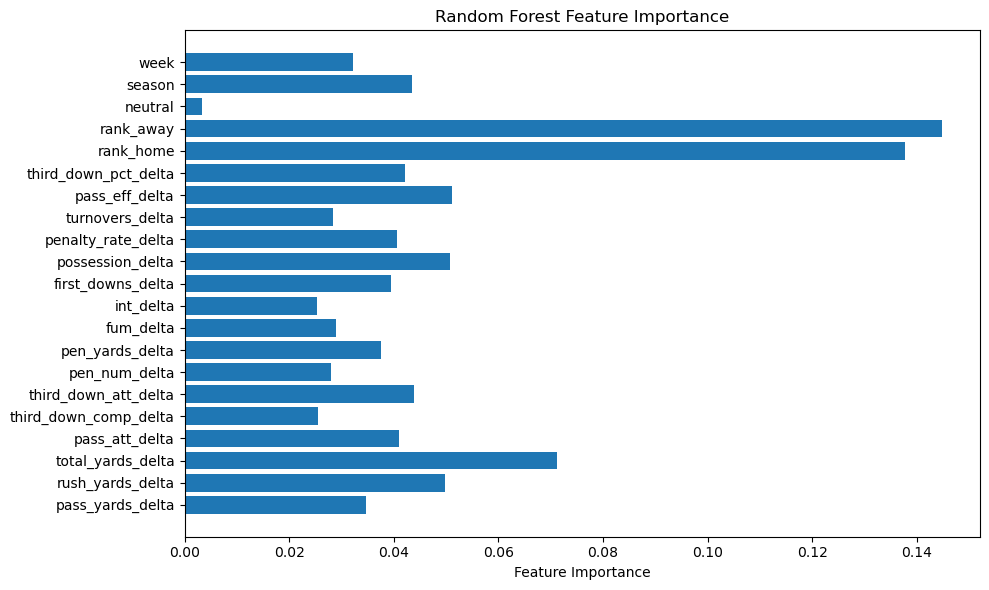

In [309]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10)
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate
mse_home_rf = mean_squared_error(y_test['score_home'], y_pred_rf[:, 0])
mae_home_rf = mean_absolute_error(y_test['score_home'], y_pred_rf[:, 0])
r2_home_rf = r2_score(y_test['score_home'], y_pred_rf[:, 0])

mse_away_rf = mean_squared_error(y_test['score_away'], y_pred_rf[:, 1])
mae_away_rf = mean_absolute_error(y_test['score_away'], y_pred_rf[:, 1])
r2_away_rf = r2_score(y_test['score_away'], y_pred_rf[:, 1])


print(f"Home Score  — MSE: {mse_home_rf:.2f}, MAE: {mae_home_rf:.2f}, R²: {r2_home_rf:.3f}")
print(f"Away Score  — MSE: {mse_away_rf:.2f}, MAE: {mae_away_rf:.2f}, R²: {r2_away_rf:.3f}")

# Feature importance
feature_names = model_features
importances = rf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


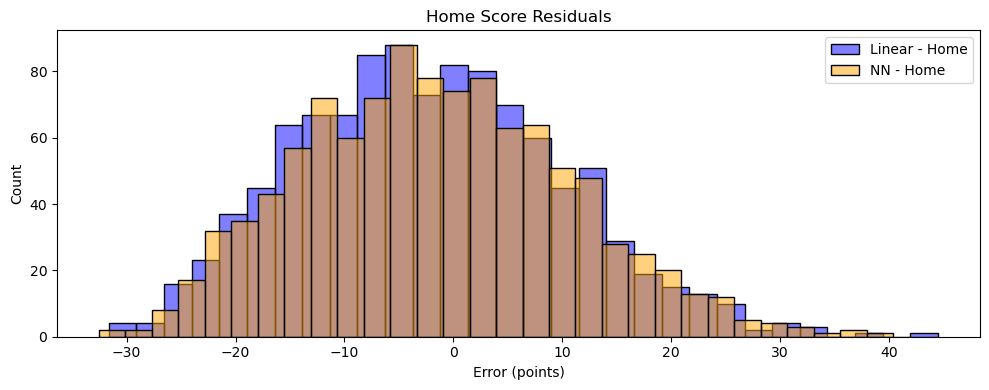

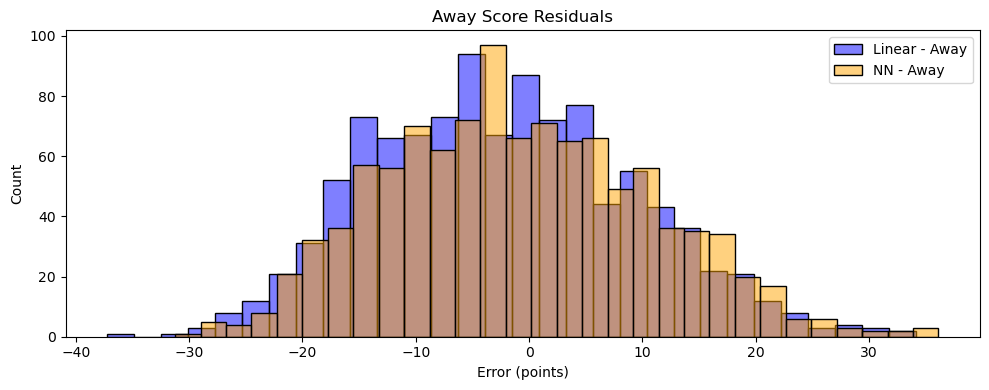

📊 Mean Absolute Error Comparison:
• Home (Linear): 10.05
• Home (NN):     10.06
• Away (Linear): 9.60
• Away (NN):     9.57


In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- Step 1: Predict on test set ---
# Predict using rolling linear regression model
y_pred_lin = model.predict(X_test_scaled)

# Predict using neural network model
with torch.no_grad():
    y_pred_nn = final_model(X_test_tensor).cpu().numpy()

# --- Step 2: Compute residuals ---
resid_home_lin = y_test['score_home'].values - y_pred_lin[:, 0]
resid_away_lin = y_test['score_away'].values - y_pred_lin[:, 1]

resid_home_nn = y_test['score_home'].values - y_pred_nn[:, 0]
resid_away_nn = y_test['score_away'].values - y_pred_nn[:, 1]

# --- Step 3: Plot residual histograms ---

# Home Residuals
plt.figure(figsize=(10, 4))
sns.histplot(resid_home_lin, bins=30, color="blue", alpha=0.5, label="Linear - Home")
sns.histplot(resid_home_nn, bins=30, color="orange", alpha=0.5, label="NN - Home")
plt.title("Home Score Residuals")
plt.xlabel("Error (points)")
plt.legend()
plt.tight_layout()
plt.show()

# Away Residuals
plt.figure(figsize=(10, 4))
sns.histplot(resid_away_lin, bins=30, color="blue", alpha=0.5, label="Linear - Away")
sns.histplot(resid_away_nn, bins=30, color="orange", alpha=0.5, label="NN - Away")
plt.title("Away Score Residuals")
plt.xlabel("Error (points)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 4: Print MAE Comparison ---
print("📊 Mean Absolute Error Comparison:")
print(f"• Home (Linear): {np.mean(np.abs(resid_home_lin)):.2f}")
print(f"• Home (NN):     {np.mean(np.abs(resid_home_nn)):.2f}")
print(f"• Away (Linear): {np.mean(np.abs(resid_away_lin)):.2f}")
print(f"• Away (NN):     {np.mean(np.abs(resid_away_nn)):.2f}")
